In [1]:
#Importing the needed packages
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import random
import time
import os
import math

In [2]:
start = time.time()
expedia_df = pd.read_csv('training_set_VU_DM_2014.csv')
#test_df = pd.read_csv('test_set_VU_DM_2014.csv')
print('Loading dataset took {} seconds'.format(time.time()-start))

Loading dataset took 33.28058838844299 seconds


In [3]:
expedia_df.shape

(4958347, 54)

In [4]:
expedia_df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [5]:
var_list = ['date_time','site_id','visitor_location_country_id','visitor_hist_starrating','visitor_hist_adr_usd','srch_id',
            'comp1_rate','comp1_inv','comp1_rate_percent_diff',
            'comp2_rate','comp2_inv','comp2_rate_percent_diff',
            'comp3_rate','comp3_inv','comp3_rate_percent_diff',
            'comp4_rate','comp4_inv','comp4_rate_percent_diff',
            'comp5_rate','comp5_inv','comp5_rate_percent_diff',
            'comp6_rate','comp6_inv','comp6_rate_percent_diff',
            'comp7_rate','comp7_inv','comp7_rate_percent_diff',
            'comp8_rate','comp8_inv','comp8_rate_percent_diff']
data = expedia_df[var_list]

In [6]:
sample_data = data.sample(10000)
expedia_df = expedia_df.sample(10000)

([<matplotlib.axis.XTick at 0x7f2e3a8f0b38>,
 <a list of 30 Text xticklabel objects>)

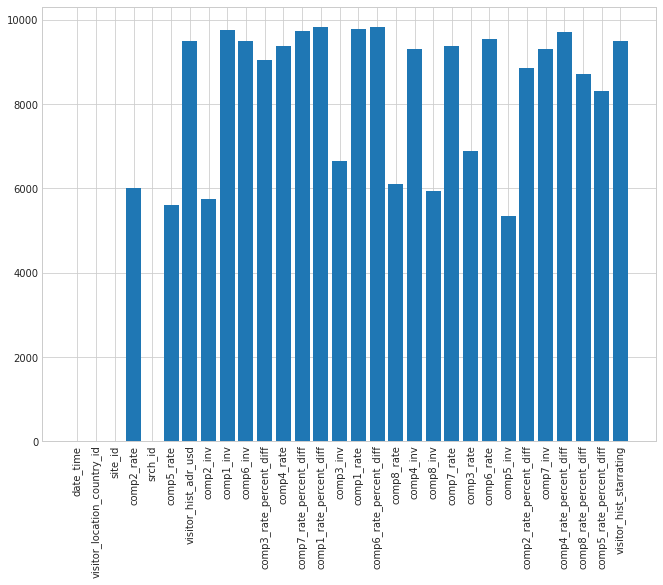

In [7]:
def get_null(prop,data):
    return sum(pd.isnull(data[prop]))

d = {prop: get_null(prop,sample_data) for prop in list(sample_data.keys())}
fig,ax = plt.subplots()
fig.set_size_inches(11,8)
plt.bar(range(len(d)),d.values(),align='center')
plt.xticks(range(len(d)),d.keys(),rotation=90)

In [9]:
comp_vars = var_list[6:]
all_vars = list(expedia_df.keys())

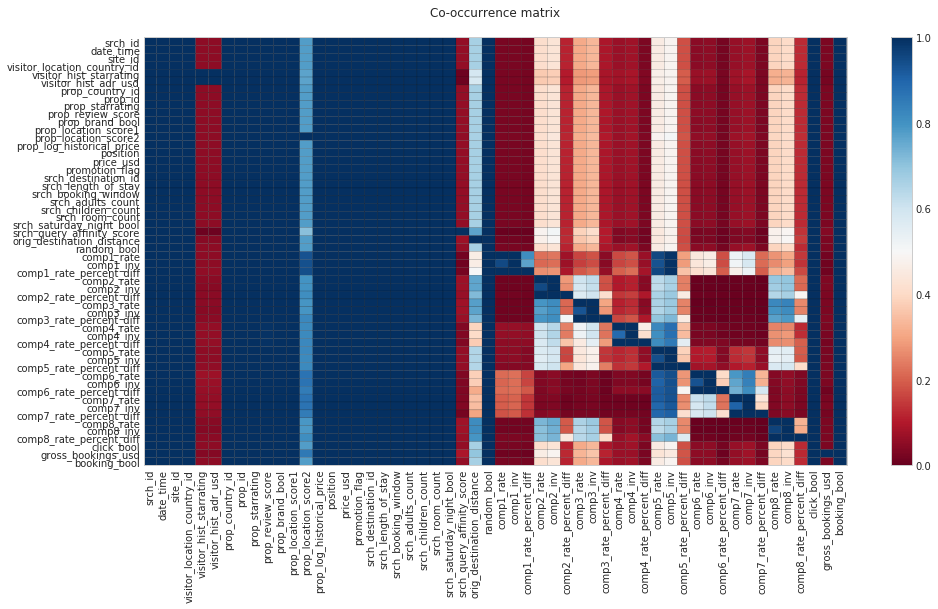

In [27]:
# PLOT COOCCURRENCE MATRIX

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''

    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
        
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False,rotation=90)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    #show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    ax.invert_yaxis()
    #ax.xaxis.tick_top()

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(40, 20))

def plot_coocurrance(data,*variables):
    var_data = data[list(variables)]
    (r,c) = var_data.shape
    M = np.zeros((r,c))
    for i in range(r):
        M[i,:]= [int(not x) for x in pd.isnull(var_data.iloc[i,:])]
    cooc_matrix = np.dot(M.transpose(), M)
    cooc_diag = np.diagonal(cooc_matrix)
    with np.errstate(divide='ignore', invalid='ignore'):
        cooc_percent = np.nan_to_num(np.true_divide(cooc_matrix, cooc_diag[:, None]))
    (x_ax_size, y_ax_size) = cooc_percent.shape
    title = 'Co-occurrence matrix\n'
    xlabel = ''
    ylabel = ''
    xticklabels = variables
    yticklabels = variables
    heatmap(cooc_percent, title, xlabel, ylabel, xticklabels, yticklabels)
    plt.show()
    
    
#plot_coocurrance(sample_data, *var_list[5:])
plot_coocurrance(expedia_df, *all_vars) 

In [19]:
def violin_plot(data, var_name, name, lolim=None, hilim=None):
    accs = []
    if lolim and not hilim:
        plt.ylim(ymin=lolim)
    elif hilim and not lolim:
        plt.ylim(ymax=hilim)
    elif hilim and lolim:
        plt.ylim(lolim, hilim)
    ax = sns.violinplot(y=data[var_name])
    plt.ylabel(var_name)
    plt.title('{}'.format(name))
    #plt.savefig(name+'_fold.png')
    plt.show()

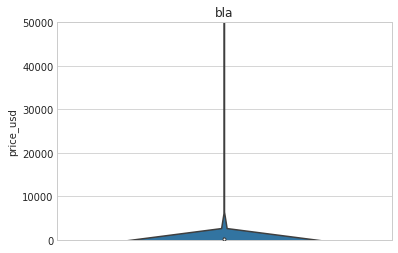

In [20]:

violin_plot(expedia_df, 'price_usd', 'bla',hilim=1000)

In [12]:
print(comp_vars)

['comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv', 'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv', 'comp8_rate_percent_diff']


In [25]:
varss = np.array(comp_vars)
sorts = np.array([0,3,6,9,12,15,18,21,1,4,7,10,13,16,19,22,2,5,8,11,14,17,20,23])
ordered_comp_vars = varss[sorts]

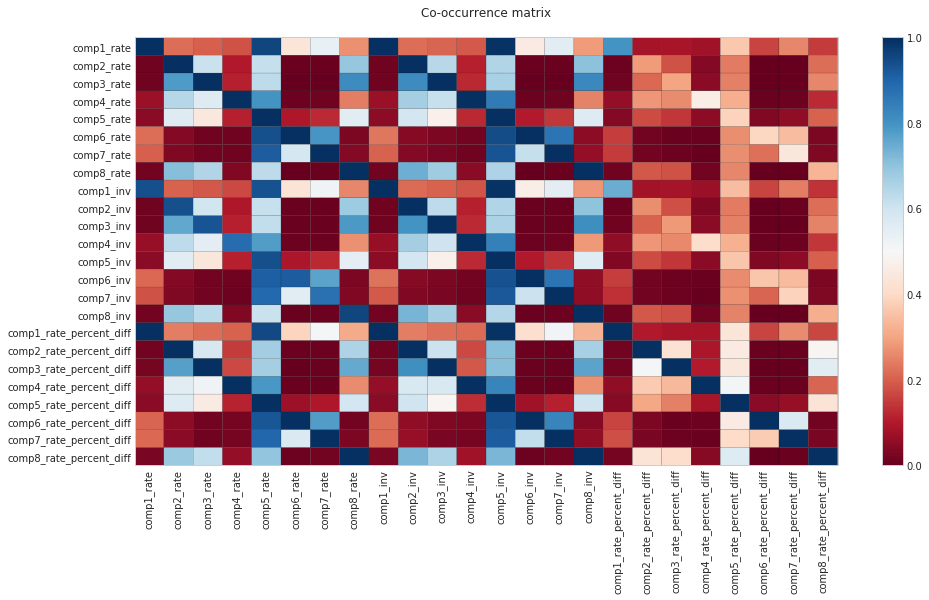

In [33]:
plot_coocurrance(sample_data, *ordered_comp_vars)

In [20]:
def combine_comps(data, comp_vars):
    
    
def normalize(data, variable):
    d = data[variable]
    mean = np.mean(d)
    norm_d = [(x-mean)/mean for x in d]
    data[variable] = norm_d
    return data
    
    

array([1, 2, 3, 5])